## 0. Import Packages

In [279]:
import numpy as np
from numpy import pi as π
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import firedrake
from firedrake import Constant, inner, sqrt, tr, grad, div, as_vector, exp,sym, as_vector, dx, ds, Mesh, Function, project, TransferManager
import meshpy, meshpy.geometry, meshpy.triangle
import irksome
from irksome import Dt
from scipy.signal import detrend
import copy
import matplotlib
import irksome
from irksome import Dt
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import pickle as pkl


# %matplotlib widget

In [18]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

## 1. Create the initial mesh

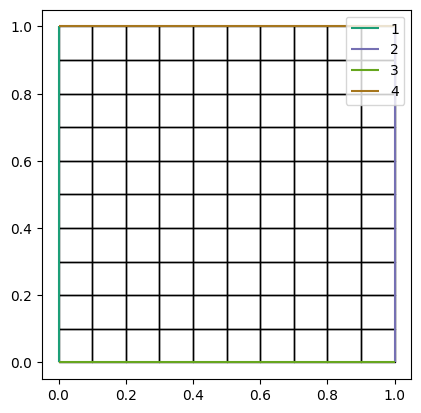

In [24]:
#Creating the initial mesh dimensions

nx, nz = 10, 10
initial_mesh = firedrake.UnitSquareMesh(nx, nz, quadrilateral=True)

fig, ax = plt.subplots()
ax.set_aspect("equal")
firedrake.triplot(initial_mesh, axes=ax)
ax.legend();

### Full mesh

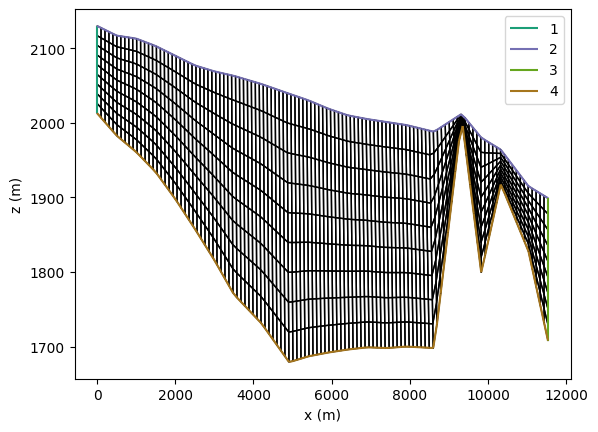

In [116]:
x, z = firedrake.SpatialCoordinate(initial_mesh)
mesh_full = Mesh('Current_meshes/ALHIC1902_full_flowline_scaled_lowres.msh')
# Input the mesh dimensions here, not sure how to do this automatically
right_boundary_heights = []

for i in mesh_full.coordinates.dat.data:
    if i[0] == np.max(mesh_full.coordinates.dat.data[:,0]):
        right_boundary_heights.append(i[1])

depth = np.max(right_boundary_heights) - np.min(right_boundary_heights)

# length = 24000

# slope = (height_max - height_min) / length


x_full, z_full = firedrake.SpatialCoordinate(mesh_full)

bed_id = [4]
left_id = [1]
surface_id = [2]
right_id = [3]

fig, ax = plt.subplots()
ax.set_aspect("auto")
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
firedrake.triplot(mesh_full, axes=ax)
# ax.set_ylim([-100,100])
# ax.set_xlim([0,500])
ax.set_aspect("auto")
ax.legend();

### Create a more reaslistic mesh with the chopped mesh

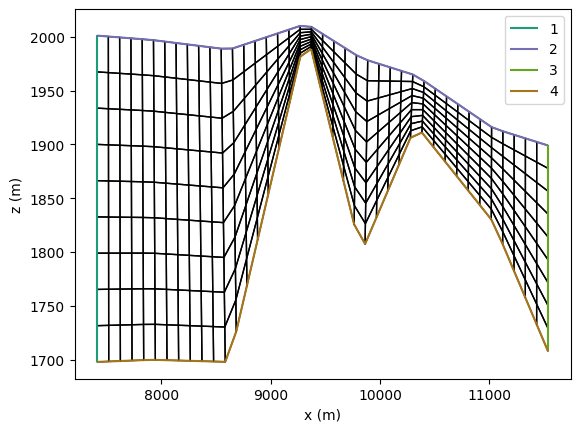

In [157]:
x, z = firedrake.SpatialCoordinate(initial_mesh)
mesh_chop = Mesh('Current_meshes/ALHIC1902_chopped_scaled_lowres.msh')
# Input the mesh dimensions here, not sure how to do this automatically
right_boundary_heights = []

for i in mesh_chop.coordinates.dat.data:
    if i[0] == np.max(mesh_chop.coordinates.dat.data[:,0]):
        right_boundary_heights.append(i[1])

depth = np.max(right_boundary_heights) - np.min(right_boundary_heights)

# length = 24000

# slope = (height_max - height_min) / length


x_chop, z_chop = firedrake.SpatialCoordinate(mesh_chop)

bed_id = [4]
left_id = [1]
surface_id = [2]
right_id = [3]

fig, ax = plt.subplots()
ax.set_aspect("auto")
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
firedrake.triplot(mesh_chop, axes=ax)
# ax.set_ylim([-100,100])
# ax.set_xlim([0,500])
ax.set_aspect("auto")
ax.legend();


### 2. Constants

In [117]:
# Constants
spy = 365.25 * 24 * 60 * 60
ρ = Constant(917.0)    # kg / m^3
c = Constant(2180)     # J / kg C
k = Constant(2.22)  # W / m C
α = (k/(ρ*c)) # diffusivity
A = 3.5e-25 
n = 3
R = 8.31446261815324
act_vol = -1.74e-5
Q = 6e4 # activatyion energy J/mol

dTdz = 2e-2 #C per 100m
geo_flux = Constant(46e-3) #W/m^2

λ = Constant(10.0)    # m
grav = Constant(-9.81) #m/s^2

vel_mpy = Constant(0.50) #m/yr
vel = vel_mpy / spy

# Surface condition
T_mean = -31 #average temp (C)
T_surface = Constant(T_mean) #

In [118]:
def ε(u):
    return sym(grad(u))

### 3. Build the pressure and velocity space

## 3.1 For full geometry

In [212]:

element = firedrake.FiniteElement("CG", "quadrilateral", 1)
V_full = firedrake.FunctionSpace(mesh_full, element)

T_full = firedrake.Function(V_full)
ϕ_full = firedrake.TestFunction(V_full)

In [213]:
pressure_space_full = firedrake.FunctionSpace(mesh_full, "CG", 1)
velocity_space_full = firedrake.VectorFunctionSpace(mesh_full, "CG", 2)
Y_full = velocity_space_full * pressure_space_full

y_full = firedrake.Function(Y_full)
u_full, p_full = firedrake.split(y_full)


μ = Constant(5e15) #Ice
# μ = Constant(1e14) #Test


v_full, q_full = firedrake.TestFunctions(y_full.function_space())

τ_full = 2 * μ * ε(u_full)
g = as_vector((0, grav))
f =  ρ * g

F_momentum_full = (inner(τ_full, ε(v_full)) - q_full * div(u_full) - p_full * div(v_full) - inner(f, v_full)) * dx

## 3.1 For chopped geometry

In [162]:

element = firedrake.FiniteElement("CG", "quadrilateral", 1)
V_chop = firedrake.FunctionSpace(mesh_chop, element)

T_chop = firedrake.Function(V_chop)
ϕ_chop = firedrake.TestFunction(V_chop)

In [163]:
pressure_space_chop = firedrake.FunctionSpace(mesh_chop, "CG", 1)
velocity_space_chop = firedrake.VectorFunctionSpace(mesh_chop, "CG", 2)
Y_chop = velocity_space_chop * pressure_space_chop

y_chop = firedrake.Function(Y_chop)
u_chop, p_chop = firedrake.split(y_chop)


μ = Constant(5e15) #Ice


v_chop, q_chop = firedrake.TestFunctions(y_chop.function_space())

τ_chop = 2 * μ * ε(u_chop)
g = as_vector((0, grav))
f =  ρ * g

F_momentum_chop = (inner(τ_chop, ε(v_chop)) - q_chop * div(u_chop) - p_chop * div(v_chop) - inner(f, v_chop)) * dx

### 3.1 Boundary conditions

### Temp boundary, full mesh

In [152]:
## We will say that the temperature is -30 at 2000 m 


In [154]:

temperature_expr_full = T_mean - (z_full - 2000)*.01

### Flow boundary conditions, full mesh

In [122]:
## Downward velocity at the divide, we will say is linear ##

w_s_divide = -0.05 / spy

divide_heights = []
for i in mesh_full.coordinates.dat.data:
    if i[0] == 0:
        divide_heights.append(i[1])

divide_depth = np.max(divide_heights) - np.min(divide_heights)

w_divide = w_s_divide * (((z_full - np.min(divide_heights)) / divide_depth))

In [123]:
## Downward velocity at the divide, we will say is linear ##

w_s_abl = 0.02 / spy

abl_boundary_heights_full = []

for i in mesh_full.coordinates.dat.data:
    if i[0] == np.max(mesh_full.coordinates.dat.data[:,0]):
        abl_boundary_heights_full.append(i[1])


abl_depth_full = np.max(abl_boundary_heights_full) - np.min(abl_boundary_heights_full)

w_abl_full = w_s_abl * (((z_full - np.min(abl_boundary_heights_full)) / abl_depth_full))

In [124]:

bc_l_full = firedrake.DirichletBC(Y_full.sub(0), as_vector((0, w_divide)), left_id)
bc_r = firedrake.DirichletBC(Y_full.sub(0), as_vector((0, w_abl_full)), right_id)
bc_b = firedrake.DirichletBC(Y_full.sub(0), as_vector((0, 0)), bed_id) 

bc_stokes_full=[bc_l_full, bc_b, bc_r]
#bc_stokes=[bc_l, bc_r]
# bc_temp = [top_temp_bc]

### Flow boundary conditions, chopped mesh

In [311]:
### For the case off the divide, we can force a parabolic shape ###

u_s_left = 0.05 / spy

left_heights_chop = []
for i in mesh_chop.coordinates.dat.data:
    if i[0] == np.min(mesh_chop.coordinates.dat.data[:,0]):
        left_heights_chop.append(i[1])

left_depth_chop = np.max(left_heights_chop) - np.min(left_heights_chop)

#u_left_chop = u_s_left * (((z_chop - np.min(left_heights_chop)) / left_depth_chop)**.33)

u_left_chop = ((2*A)/(n+1))*((ρ*9.81*left_depth_chop*(1/180))**n)*left_depth_chop*(1-(1-((z_chop - np.min(left_heights_chop))/left_depth_chop)**(n+1)))

In [304]:
## Downward velocity at the divide, we will say is linear ##

w_s_abl = 0.02 / spy

abl_boundary_heights_chop = []

for i in mesh_chop.coordinates.dat.data:
    if i[0] == np.max(mesh_chop.coordinates.dat.data[:,0]):
        abl_boundary_heights_chop.append(i[1])


abl_depth_chop = np.max(abl_boundary_heights_chop) - np.min(abl_boundary_heights_chop)

w_abl_chop = w_s_abl * (((z_chop - np.min(abl_boundary_heights_chop)) / abl_depth_chop))

In [305]:

bc_l_chop = firedrake.DirichletBC(Y_chop.sub(0), as_vector((u_left_chop, 0)), left_id)
bc_r = firedrake.DirichletBC(Y_chop.sub(0), as_vector((0, w_abl_chop)), right_id)
bc_b = firedrake.DirichletBC(Y_chop.sub(0), as_vector((0, 0)), bed_id) 

bc_stokes_chop=[bc_l_chop, bc_b, bc_r]

### 4. Building the stokes solver

### Full mesh stokes

In [214]:
basis = firedrake.VectorSpaceBasis(constant=True, comm=firedrake.COMM_WORLD)
nullspace_full = firedrake.MixedVectorSpaceBasis(Y_full, [Y_full.sub(0), basis])

stokes_problem_full = firedrake.NonlinearVariationalProblem(F_momentum_full, y_full, bc_stokes_full)
parameters = {
    "nullspace": nullspace_full,
    "solver_parameters": {
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
}
stokes_solver_full = firedrake.NonlinearVariationalSolver(stokes_problem_full, **parameters)

stokes_solver_full.solve()

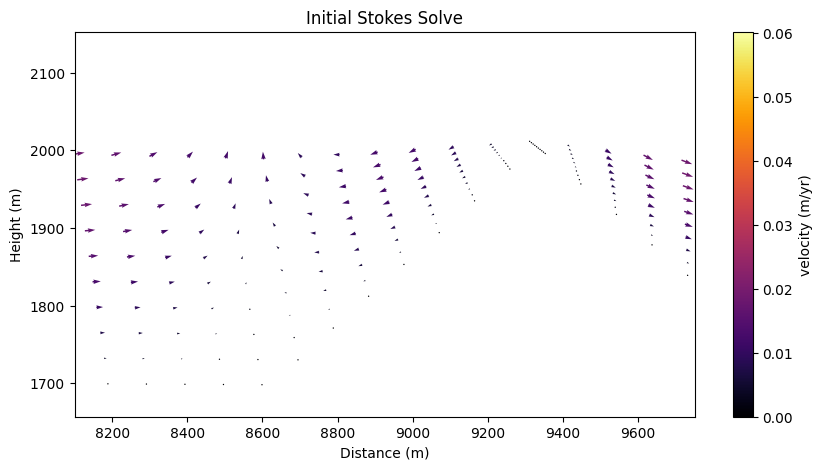

In [215]:
fig, axes = plt.subplots(figsize = [10,5])
vel_field_plot_full = firedrake.quiver(y_full.sub(0)*spy, axes=axes, cmap="inferno", scale=1);
fig.colorbar(vel_field_plot_full, label='velocity (m/yr)')
axes.set_ylabel('Height (m)')
axes.set_xlabel('Distance (m)')
axes.set_title('Initial Stokes Solve')
axes.set_xlim([8100,9750])
# axes.set_ylim([1700,1800])
plt.show()
# fig.savefig('Test_model_flowfield.png')


### Chopped mesh stokes

In [308]:
basis = firedrake.VectorSpaceBasis(constant=True, comm=firedrake.COMM_WORLD)
nullspace_chop = firedrake.MixedVectorSpaceBasis(Y_chop, [Y_chop.sub(0), basis])

stokes_problem_chop = firedrake.NonlinearVariationalProblem(F_momentum_chop, y_chop, bc_stokes_chop)
parameters = {
    "nullspace": nullspace_chop,
    "solver_parameters": {
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
}
stokes_solver_chop = firedrake.NonlinearVariationalSolver(stokes_problem_chop, **parameters)

stokes_solver_chop.solve()

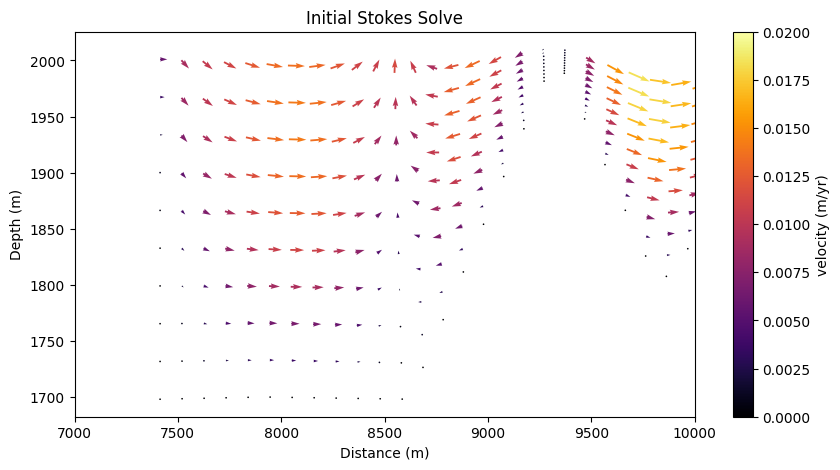

In [314]:
fig, axes = plt.subplots(figsize = [10,5])
vel_field_plot_chop = firedrake.quiver(y_chop.sub(0)*spy, axes=axes, cmap="inferno", scale=.5);
fig.colorbar(vel_field_plot_chop, label='velocity (m/yr)')
axes.set_ylabel('Depth (m)')
axes.set_xlabel('Distance (m)')
axes.set_title('Initial Stokes Solve')
axes.set_xlim([7000,10000])
# axes.set_ylim([-1200,-800])
plt.show()
# fig.savefig('Test_model_flowfield.png')



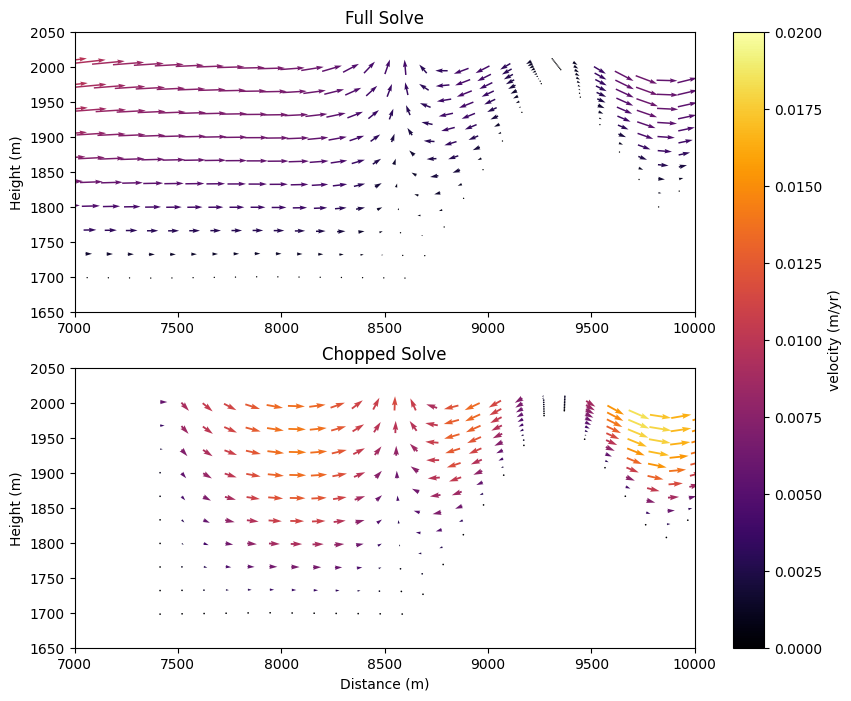

In [310]:
### Plot them both

fig, axes = plt.subplots(2,1,figsize = [10,8])
vel_field_plot_full = firedrake.quiver(y_full.sub(0)*spy, axes=axes[0], cmap="inferno", scale=.5);
vel_field_plot_chop = firedrake.quiver(y_chop.sub(0)*spy, axes=axes[1], cmap="inferno", scale=.5);
fig.colorbar(vel_field_plot_chop, label='velocity (m/yr)', ax=axes)
axes[0].set_ylabel('Height (m)')
#axes[0].set_xlabel('Distance (m)')
axes[0].set_title('Full Solve')
axes[1].set_ylabel('Height (m)')
axes[1].set_xlabel('Distance (m)')
axes[1].set_title('Chopped Solve')

axes[0].set_xlim([7000,10000])
axes[1].set_xlim([7000,10000])


axes[0].set_ylim([1650,2050])
axes[1].set_ylim([1650,2050])

plt.show()
#fig.savefig('ALHIC1902_flowfield_comparison_vectors.png')


/home/firedrake/firedrake/src/firedrake/firedrake/pyplot/mpl.py:218: UserWarning: The following kwargs were not used by contour: 'scale'
  return method(triangulation, toreal(values, complex_component), *args, **kwargs)


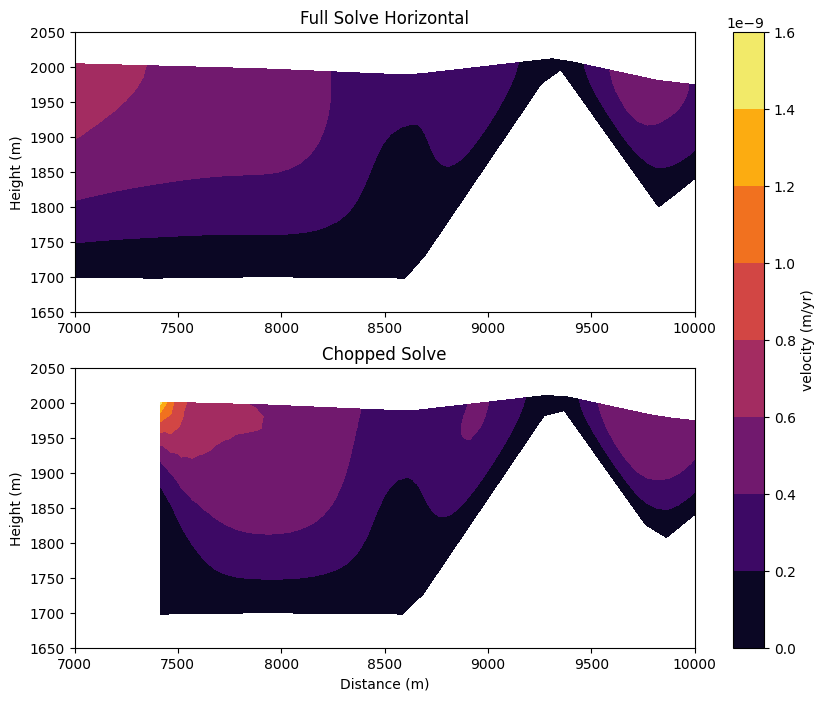

In [296]:
### Plot them both

fig, axes = plt.subplots(2,1,figsize = [10,8])
vel_field_plot_full = firedrake.tricontourf(y_full.sub(0), axes=axes[0], cmap="inferno", scale=1);
vel_field_plot_chop = firedrake.tricontourf(y_chop.sub(0), axes=axes[1], cmap="inferno", scale=1);
fig.colorbar(vel_field_plot_chop, label='velocity (m/yr)', ax=axes)
axes[0].set_ylabel('Height (m)')
#axes[0].set_xlabel('Distance (m)')
axes[0].set_title('Full Solve Horizontal')
axes[1].set_ylabel('Height (m)')
axes[1].set_xlabel('Distance (m)')
axes[1].set_title('Chopped Solve')

axes[0].set_xlim([7000,10000])
axes[1].set_xlim([7000,10000])


axes[0].set_ylim([1650,2050])
axes[1].set_ylim([1650,2050])

plt.show()
fig.savefig('ALHIC1902_flowfield_comparison_contour.png')

## Get the velocity at the borehole

#### Full mesh

In [324]:
borehole_locs = pd.read_csv("Borehole_locations_distance.csv")
borehole_loc = borehole_locs[borehole_locs['Borehole'] == 'ALHIC1902']

x_loc = borehole_loc["Borehole_Distance"].values[0] - 1300 #This was given wrong I think so hence the minus 1000
y_values = np.linspace(np.min(mesh_full.coordinates.dat.data[:,1]), np.max(mesh_full.coordinates.dat.data[:,1]), 50)

In [325]:
## Get nearest x location in mesh ##

x_nearest = find_nearest(mesh_full.coordinates.dat.data[:,0],x_loc)

In [326]:
borehole_mesh_values_full = []

for i in mesh_full.coordinates.dat.data:

    if x_nearest - 130 < i[0] < x_nearest + -30:
        print(i)
        borehole_mesh_values_full.append(i)

borehole_mesh_values_full_arr = np.array(borehole_mesh_values_full)

[8400.59547871 1990.80571526]
[8411.23590441 1958.31092361]
[8421.8763301  1925.81613195]
[8432.5167558  1893.32134029]
[8443.1571815  1860.82654864]
[8453.7976072  1828.33175698]
[8464.43803289 1795.83696532]
[8475.07845859 1763.34217367]
[8485.71888429 1730.84738201]
[8393.84959167 1698.64257541]


In [327]:
velocity_profile_full = []
borehole_y_val_full = []

for x_val, y_val in borehole_mesh_values_full:
    point = (x_val, y_val)
    velocity_profile_full.append(y_full.sub(0).at(point))
    borehole_y_val_full.append(y_val)

velocity_profile_full = np.array(velocity_profile_full)

In [328]:
# Define a line from (x0, y0) to (x1, y1)
num_points = 20

x_vals = np.linspace(x_loc, x_loc, num_points)
y_vals = np.linspace(borehole_mesh_values_full_arr[:,1][0], borehole_mesh_values_full_arr[:,1][-2], num_points)

# Sample values along the line
velocity_profile_values = np.array([y_full.sub(0).at(x, y) for x, y in zip(x_vals, y_vals)])

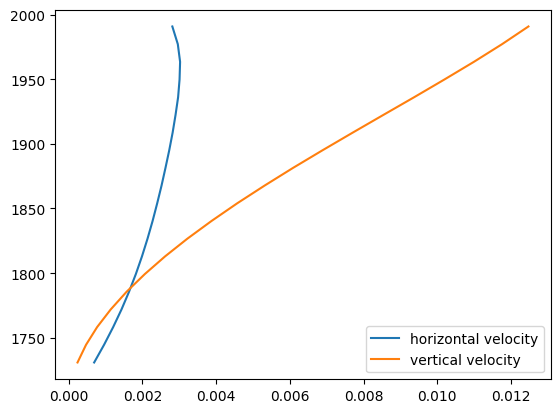

In [329]:
fig,ax = plt.subplots()

ax.plot(velocity_profile_values[:,0]*spy, y_vals, label='horizontal velocity')

ax.plot(velocity_profile_values[:,1]*spy, y_vals, label='vertical velocity')
ax.legend()

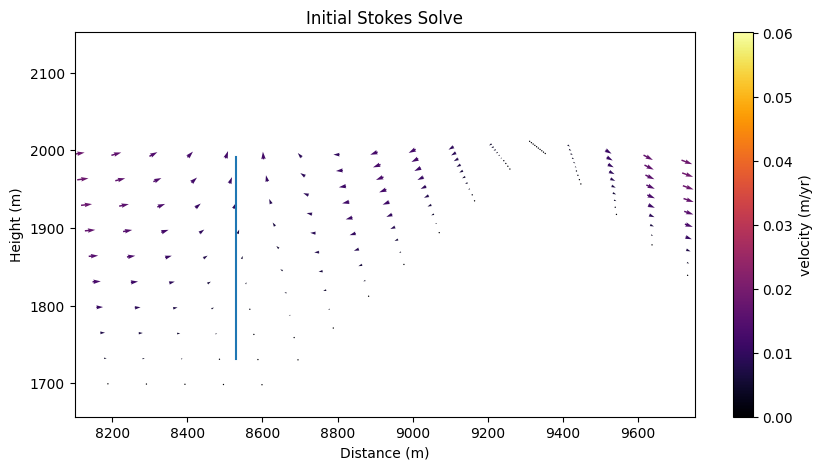

In [330]:
fig, axes = plt.subplots(figsize = [10,5])
vel_field_plot_full = firedrake.quiver(y_full.sub(0)*spy, axes=axes, cmap="inferno", scale=1);

axes.plot(x_vals,y_vals)
fig.colorbar(vel_field_plot_full, label='velocity (m/yr)')
axes.set_ylabel('Height (m)')
axes.set_xlabel('Distance (m)')
axes.set_title('Initial Stokes Solve')
axes.set_xlim([8100,9750])
# axes.set_ylim([1700,1800])
plt.show()
# fig.savefig('Test_model_flowfield.png')

### Chopped Mesh

In [81]:
borehole_mesh_values_chopped = []

for i in mesh_chop.coordinates.dat.data:

    if x_nearest - 70< i[0] < x_nearest + 50:
        print(i)
        borehole_mesh_values_chopped.append(i)

NameError: name 'mesh_chop' is not defined

In [332]:
velocity_profile_chop = []
borehole_y_val_chop = []

for x_val, y_val in borehole_mesh_values_chopped:
    point = (x_val, y_val)
    velocity_profile_chop.append(y_full.sub(0).at(point))
    borehole_y_val_chop.append(y_val)

velocity_profile_chop = np.array(velocity_profile_chop)

NameError: name 'velocity_profile_chop' is not defined

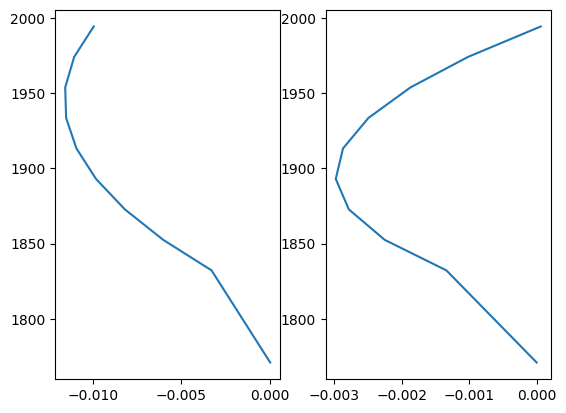

In [84]:
fig, ((ax1, ax2)) = plt.subplots(1,2)

ax1.plot(velocity_profile_full[:,0]*spy, borehole_y_val_full, label='Full Mesh')
ax2.plot(velocity_profile_full[:,1]*spy, borehole_y_val_full)

ax1.plot(velocity_profile_chop[:,0]*spy, borehole_y_val_chop, label='Chopped Mesh')
ax2.plot(velocity_profile_chop[:,1]*spy, borehole_y_val_chop)

ax1.set_ylabel('Elevation (m)')
ax1.set_xlabel('Horizontal Velocity (m/yr)')
ax2.set_xlabel('Vertical Velocity (m/yr)')

ax1.legend()

fig.suptitle('ALHIC1902 velocity components')
plt.tight_layout()


# plt.savefig('ALHIC1902_borehole_velocity_component_comparison.png')

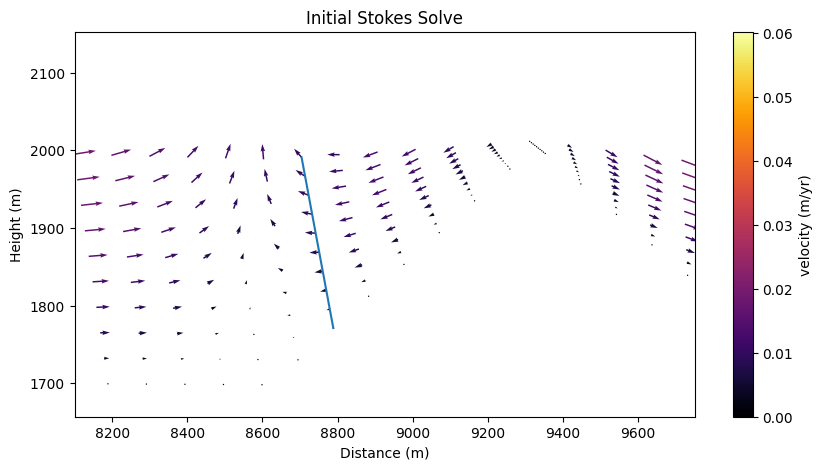

In [101]:
fig, axes = plt.subplots(figsize = [10,5])
vel_field_plot_full = firedrake.quiver(y_full.sub(0)*spy, axes=axes, cmap="inferno", scale=.5);
fig.colorbar(vel_field_plot_full, label='velocity (m/yr)')

axes.plot(borehole_mesh_values_full_arr[:,0], borehole_mesh_values_full_arr[:,1])
axes.set_ylabel('Height (m)')
axes.set_xlabel('Distance (m)')
axes.set_title('Initial Stokes Solve')
axes.set_xlim([8100,9750])
# axes.set_ylim([1700,1800])
plt.show()
# fig.savefig('Test_model_flowfield.png')

/home/firedrake/firedrake/src/firedrake/firedrake/pyplot/mpl.py:218: UserWarning: The following kwargs were not used by contour: 'scale'
  return method(triangulation, toreal(values, complex_component), *args, **kwargs)


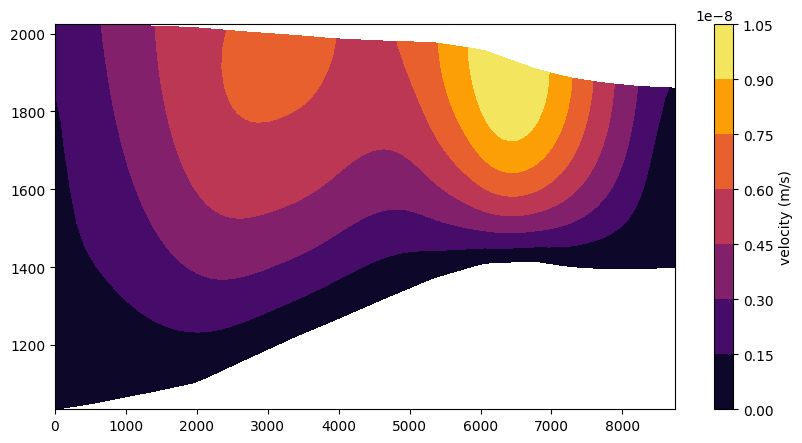

In [88]:
fig, axes = plt.subplots(figsize = [10,5])
vel_field_plot = firedrake.tricontourf(y.sub(0), axes=axes, cmap="inferno", scale=3);
fig.colorbar(vel_field_plot, label='velocity (m/s)')

/home/firedrake/firedrake/src/firedrake/firedrake/pyplot/mpl.py:218: UserWarning: The following kwargs were not used by contour: 'scale'
  return method(triangulation, toreal(values, complex_component), *args, **kwargs)


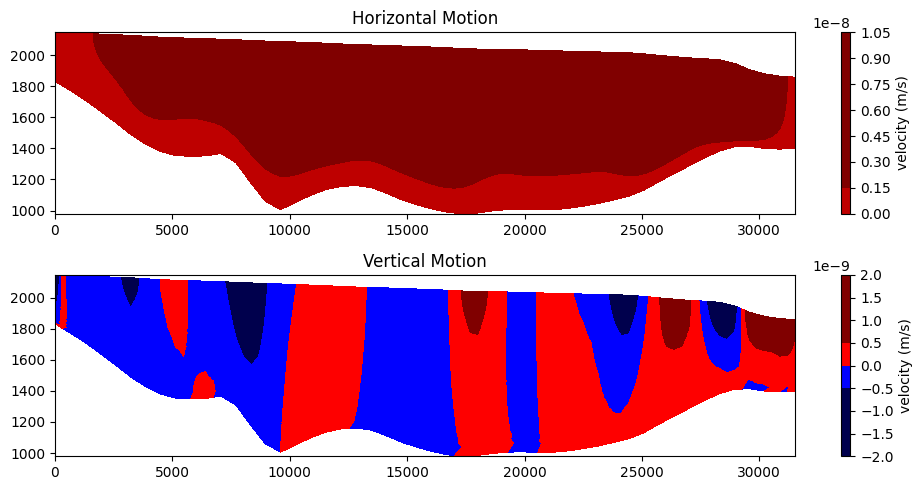

In [257]:
fig, (ax1, ax2)= plt.subplots(2,1, figsize = [10,5])
vel_field_plot1 = firedrake.tricontourf(y.sub(0).sub(0), axes=ax1, cmap="seismic", scale=3, vmin=-1e-9, vmax=1e-9);
vel_field_plot2 = firedrake.tricontourf(y.sub(0).sub(1), axes=ax2, cmap="seismic", scale=3, vmin=-5e-10, vmax=5e-10);
fig.colorbar(vel_field_plot1, label='velocity (m/s)', ax=ax1)
fig.colorbar(vel_field_plot2, label='velocity (m/s)', ax=ax2)

ax1.set_title('Horizontal Motion')

ax2.set_title('Vertical Motion')

plt.tight_layout()


In [258]:
# fig, axes = plt.subplots(figsize = [10,5])

# fig.colorbar(vel_field_plot, label='velocity (m/yr)')

## Full mesh temperature

### 5. Temperature

### 5.1 Just diffusion

In [233]:
geothermal_flux = -geo_flux*ϕ_full  * ds((bed_id[0]))

F = k * inner(grad(T_full), grad(ϕ_full)) * dx + geothermal_flux

# surf_bc = firedrake.DirichletBC(V, T_surface, surf_ids)
#surf_bc = firedrake.DirichletBC(V, T_surface+(slope / (1/100))*(1 + (x/length)), surface_id) #slope / (1/100) term is the dry adiabat following the slope
top_temp_bc = firedrake.DirichletBC(V_full, temperature_expr_full, surface_id)
bcs = [top_temp_bc]

firedrake.solve(F == 0, T_full, bcs)

### 5.2 Diffusion and advection

### 5.2.1 Construct the boundary conditions

In [234]:

# bcs_init = [upper_bc_init]

In [260]:
F_diffusion = k * inner(grad(T_full), grad(ϕ_full)) * dx
F_advection = - ρ * c * T_full * inner(u_full, grad(ϕ_full)) * dx

F_0 = F_advection + F_diffusion + geothermal_flux

top_temp_bc = firedrake.DirichletBC(V_full, temperature_expr_full, surface_id)
bcs = [top_temp_bc]
firedrake.solve(F_0 == 0, T_full, bcs)

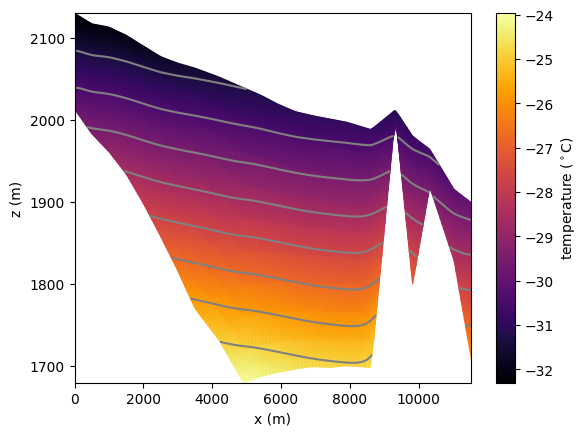

In [261]:
fig, ax = plt.subplots()
ax.set_aspect("auto")
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
colors = firedrake.tripcolor(T_full, cmap="inferno", axes=ax)
fig.colorbar(colors, label="temperature (${}^\circ$C)")
levels = np.linspace(T_full.dat.data.min(), T_full.dat.data.max(), 10)
firedrake.tricontour(T_full, levels=levels, colors="grey", axes=ax)
# ax.set_xlim([9000,10000]);

### Compare to boreholes

In [237]:
# borehole_locs = pd.read_csv("Borehole_locations_distance.csv")
# borehole_loc = borehole_locs[borehole_locs['Borehole'] == 'ALHIC1902']

# x_loc = borehole_loc["Borehole_Distance"].values[0]  -1000
# y_values = np.linspace(np.min(mesh_full.coordinates.dat.data[:,1]), np.max(mesh_full.coordinates.dat.data[:,1]), 50)

In [319]:
borehole_mesh_values = []

for i in mesh_full.coordinates.dat.data:

    if x_nearest - 130 < i[0] < x_nearest + -30:
        print(i)
        borehole_mesh_values.append(i)
borehole_mesh_values_full_arr = np.array(borehole_mesh_values_full)
# Define a line from (x0, y0) to (x1, y1)
num_points = 20


x_vals = np.linspace(x_loc, x_loc, num_points)
y_vals = np.linspace(borehole_mesh_values_full_arr[:,1][0], borehole_mesh_values_full_arr[:,1][-2], num_points)

# Sample values along the line
temp_profile_values = np.array([T_full.sub(0).at(x, y) for x, y in zip(x_vals, y_vals)])

[8906.55192461 1997.69341753]
[8914.33861239 1981.60846469]
[8922.12530017 1965.52351186]
[8929.91198795 1949.43855902]
[8937.69867572 1933.35360619]
[8945.4853635  1917.26865335]
[8953.27205128 1901.18370052]
[8961.05873906 1885.09874768]
[8968.84542684 1869.01379484]
[8976.63211461 1852.92884201]


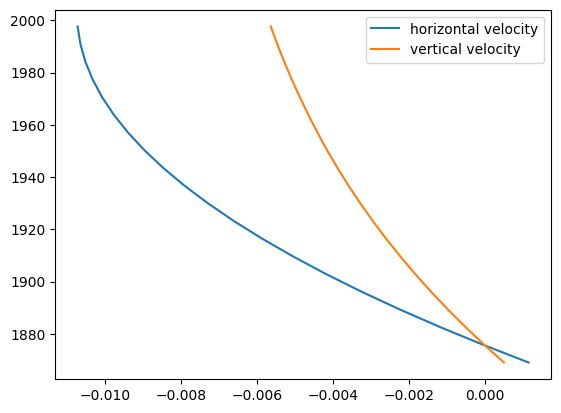

In [320]:
fig,ax = plt.subplots()

ax.plot(velocity_profile_values[:,0]*spy, y_vals, label='horizontal velocity')

ax.plot(velocity_profile_values[:,1]*spy, y_vals, label='vertical velocity')
ax.legend()

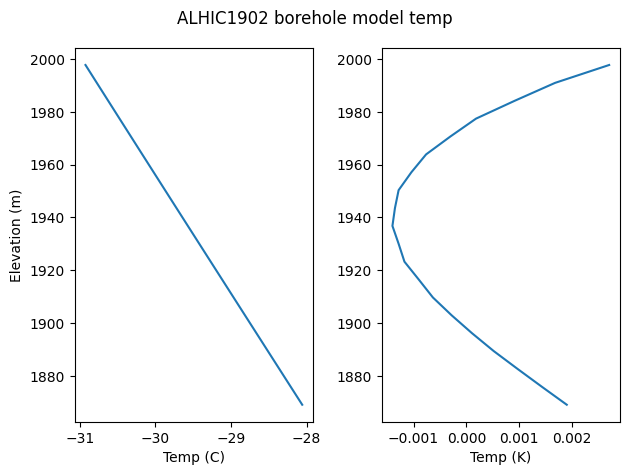

In [321]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(temp_profile_values, y_vals)
ax2.plot(scipy.signal.detrend(temp_profile_values), y_vals)

ax1.set_ylabel('Elevation (m)')
ax1.set_xlabel('Temp (C)')
ax2.set_xlabel('Temp (K)')
fig.suptitle('ALHIC1902 borehole model temp')
plt.tight_layout()
plt.savefig('ALHIC1902_modeled_temp.png')

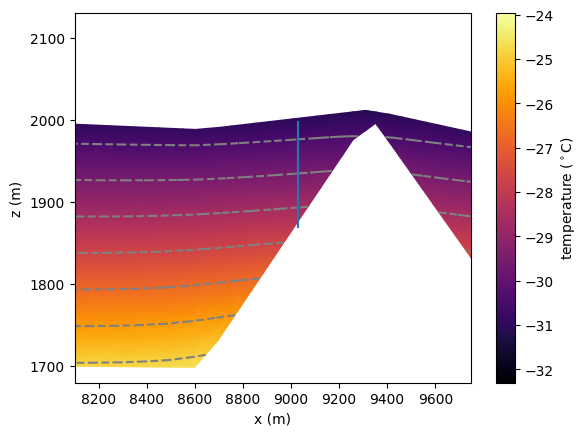

In [322]:
fig, ax = plt.subplots()
ax.set_aspect("auto")
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
colors = firedrake.tripcolor(T_full, cmap="inferno", axes=ax)
fig.colorbar(colors, label="temperature (${}^\circ$C)")
levels = np.linspace(T_full.dat.data.min(), T_full.dat.data.max(), 10)
firedrake.tricontour(T_full, levels=levels, colors="grey", axes=ax)

ax.plot(x_vals, y_vals)
ax.set_xlim([8100,9750])
plt.savefig('ALHIC1902_borehole_loc_in_temp.png')

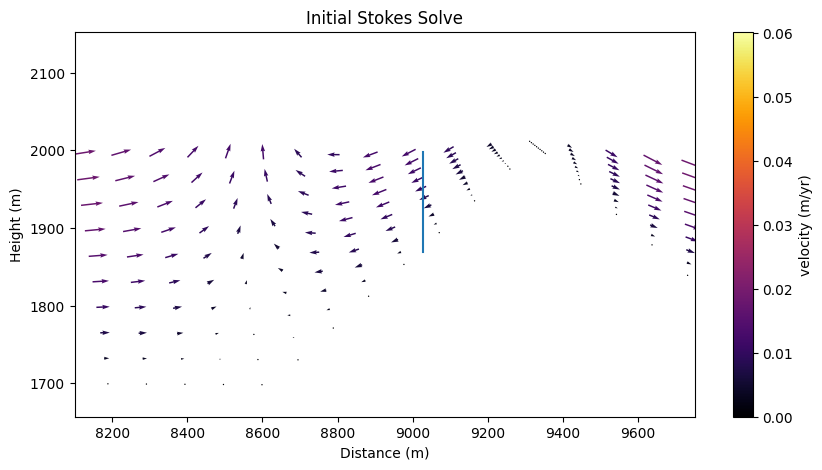

In [323]:
fig, axes = plt.subplots(figsize = [10,5])
vel_field_plot_full = firedrake.quiver(y_full.sub(0)*spy, axes=axes, cmap="inferno", scale=.5);
fig.colorbar(vel_field_plot_full, label='velocity (m/yr)')

axes.plot(x_vals,y_vals)
axes.set_ylabel('Height (m)')
axes.set_xlabel('Distance (m)')
axes.set_title('Initial Stokes Solve')
axes.set_xlim([8100,9750])
# axes.set_ylim([1700,1800])

plt.savefig('ALHIC1902_borehole_loc_in_flow.png')

plt.show()

## Get real borehole temps

In [287]:
with open('borehole_temps/AH_borehole_temps_averaged.pickle', 'rb') as temps_f:
    real_temp_data = pkl.load(temps_f)
    

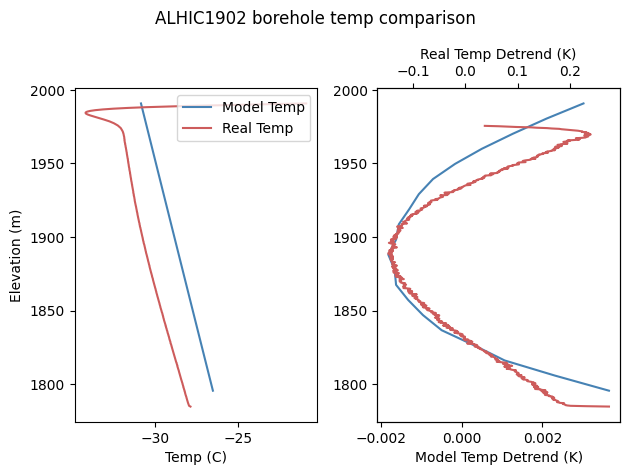

In [311]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(temp_profile_values, y_vals, label='Model Temp', c='steelblue')
ax2.plot(scipy.signal.detrend(temp_profile_values), y_vals, label='Model Temp', c='steelblue')

ax1.plot(real_temp_data['ALHIC1902_23'][1], (real_temp_data['ALHIC1902_23'][0]-real_temp_data['ALHIC1902_23'][0][-1])[::-1]+y_vals[0], label='Real Temp',c='indianred')

ax3 = ax2.twiny()
ax3.plot(scipy.signal.detrend(real_temp_data['ALHIC1902_23'][1][60:]), (real_temp_data['ALHIC1902_23'][0]-real_temp_data['ALHIC1902_23'][0][-1])[::-1][60:]+y_vals[0], label='Real Temp',c='indianred')

ax1.set_ylabel('Elevation (m)')
ax1.set_xlabel('Temp (C)')
ax2.set_xlabel('Model Temp Detrend (K)')
ax3.set_xlabel('Real Temp Detrend (K)')
fig.suptitle('ALHIC1902 borehole temp comparison')
ax1.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('ALHIC1902_borehole_temp_comparison.png')

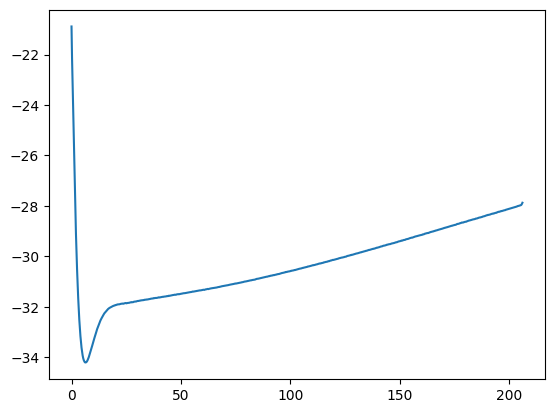

In [293]:
fig, ax = plt.subplots()
ax.plot(real_temp_data['ALHIC1902_23'][0]-real_temp_data['ALHIC1902_23'][0][0], real_temp_data['ALHIC1902_23'][1])